## I. Data Setting

In [1]:
import warnings
warnings.filterwarnings('ignore')## I. Data Setting

In [2]:
import tensorflow as tf

tf.__version__

'2.7.1'

In [3]:
print('GPU Information -', tf.test.gpu_device_name(), '\n')

!nvidia-smi

GPU Information - /device:GPU:0 

Tue Nov 22 09:51:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   35C    P0    26W /  70W |    265MiB / 15360MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                      

### 2) Image_File Directory Setting
- train_dir
- valid_dir
- test_dir

In [4]:
train_dir = 'split/train' # /content/split/train
valid_dir = 'split/val'
test_dir  = 'split/test'

### 3) ImageDataGenerator( ) & flow_from_directory( )

#### Normalization & Augmentation
- ImageDataGenerator()

#### Resizing & Generator
- flow_from_directory()

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_size = 150

# 이미지의 크기를 같게 만들어 준다 With normalization
# 각 pixel에 1/255를 곱함으로써 0~1 사이로 범위를 조정해 준다 
train_datagen = ImageDataGenerator(rescale = 1./255
                                   )
valid_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
                  train_dir,
                  target_size = (img_size,img_size),
                  batch_size = batch_size, 
                  class_mode = 'categorical')

valid_generator = valid_datagen.flow_from_directory(
                  valid_dir,
                  target_size = (img_size,img_size),
                  batch_size = batch_size,
                  class_mode = 'categorical')

Found 2112 images belonging to 4 classes.
Found 704 images belonging to 4 classes.


### 4) Test train_generator

In [6]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break## III. Import VGG-16 Model & Some Layers Freezing

배치 데이터 크기: (32, 150, 150, 3)
배치 레이블 크기: (32, 4)


## III. Import EfficientNet

### 1) conv_base

In [7]:
from tensorflow.keras.applications import EfficientNetB4

conv_base = EfficientNetB4(weights = 'imagenet',
                  include_top = False, # DNN 제외 
                  input_shape = (150, 150, 3)) # input shape을 여기서 바꾼다 

71696384/71686520 [==============================] - 1s 0us/step


### 2) Model Information

In [8]:
conv_base.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 151, 151, 3)  0           ['normalization[0][0

## IV. CNN Keras Modeling

### 1) Model Define
- Feature Extraction & Classification

In [9]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(conv_base)    # freez 없이
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.5))
# model.add(layers.Dense(128, activation = 'relu'))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(4, activation = 'softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 5, 5, 1792)       17673823  
                                                                 
 flatten (Flatten)           (None, 44800)             0         
                                                                 
 dense (Dense)               (None, 256)               11469056  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 29,143,907
Trainable params: 29,018,700
Non-trainable params: 125,207
_________________________________________________________________


### 2) Model Compile
- 모델 학습방법 설정

In [11]:
from tensorflow.keras import optimizers

model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr = 0.000005),
              metrics = ['accuracy'])

### 3) Model fit
- 모델 학습 수행

In [12]:
%%time

steps_per_epoch = int(train_generator.n//train_generator.batch_size)
validation_steps = int(valid_generator.n//valid_generator.batch_size)

Hist_dandc = model.fit(train_generator, 
                       steps_per_epoch = steps_per_epoch,
                       epochs = 50, 
                       validation_data = valid_generator,
                       validation_steps = validation_steps )

Epoch 1/50
66/66 [==============================] - 47s 434ms/step - loss: 1.7609 - accuracy: 0.2760 - val_loss: 1.5124 - val_accuracy: 0.2486
Epoch 2/50
66/66 [==============================] - 26s 387ms/step - loss: 1.5984 - accuracy: 0.2874 - val_loss: 1.5617 - val_accuracy: 0.2500
Epoch 3/50
66/66 [==============================] - 26s 387ms/step - loss: 1.4914 - accuracy: 0.3362 - val_loss: 1.5547 - val_accuracy: 0.2599
Epoch 4/50
66/66 [==============================] - 26s 390ms/step - loss: 1.3869 - accuracy: 0.3745 - val_loss: 1.4681 - val_accuracy: 0.2528
Epoch 5/50
66/66 [==============================] - 26s 394ms/step - loss: 1.3308 - accuracy: 0.3977 - val_loss: 1.4828 - val_accuracy: 0.2500
Epoch 6/50
66/66 [==============================] - 26s 397ms/step - loss: 1.2723 - accuracy: 0.4261 - val_loss: 1.5039 - val_accuracy: 0.2415
Epoch 7/50
66/66 [==============================] - 26s 397ms/step - loss: 1.2337 - accuracy: 0.4541 - val_loss: 1.5182 - val_accuracy: 0.2472

### 4) 학습 결과 시각화
- Loss Visualization

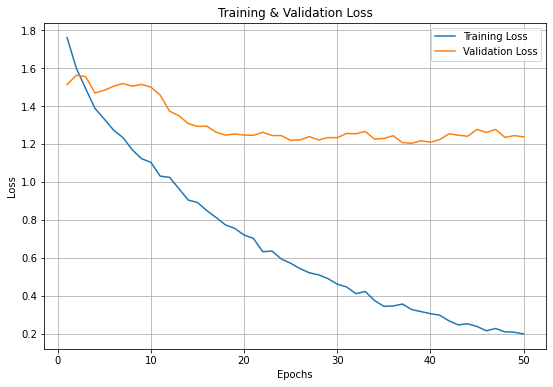

In [13]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['loss'])
plt.plot(epochs, Hist_dandc.history['val_loss'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

- Accuracy Visualization

Text(0.5, 0, 'Epochs')

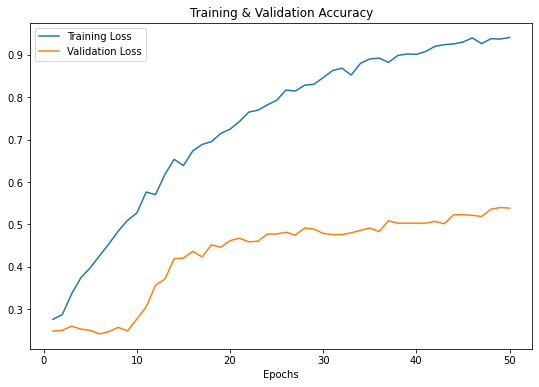

In [14]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['accuracy'])
plt.plot(epochs, Hist_dandc.history['val_accuracy'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')


### 5) Model Evaluate

- test_generator

In [15]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
                 test_dir,
                 target_size = (150, 150),
                 batch_size = 32,
                 class_mode = 'categorical')

Found 704 images belonging to 4 classes.


- Loss & Accuracy

In [16]:
loss, accuracy = model.evaluate(test_generator,
                                steps = validation_steps)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

22/22 [==============================] - 2s 81ms/step - loss: 1.3314 - accuracy: 0.4986
Loss = 1.33135
Accuracy = 0.49858
